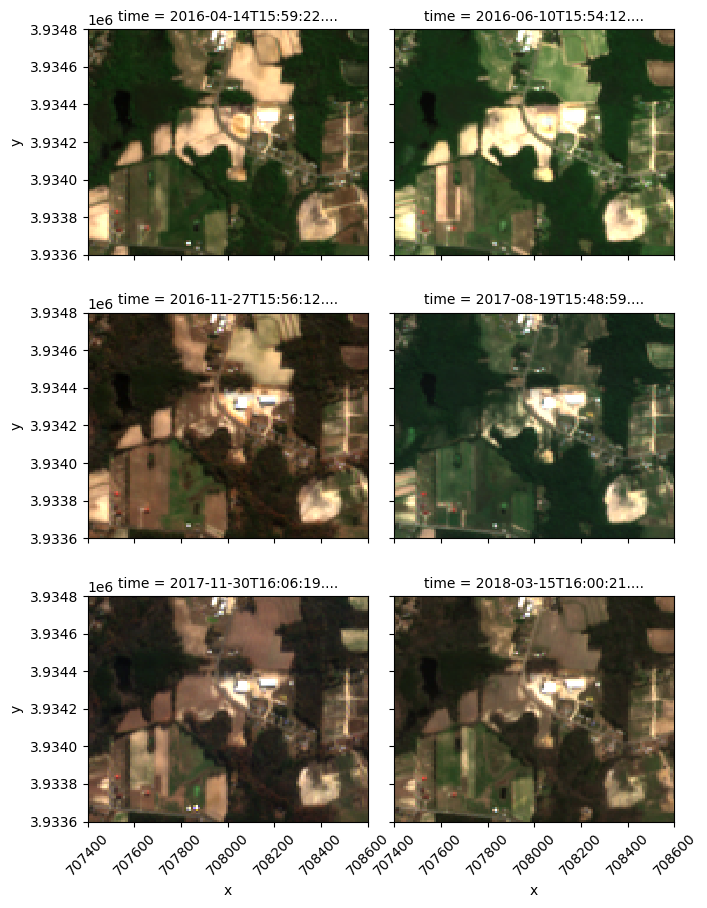

In [9]:
import geopandas as gpd
import numpy as np
import rioxarray
import xarray as xr
import rasterio
import rasterio.plot
import rasterio.warp
from rasterio.merge import merge
import matplotlib.pyplot as plt


import json
updated_tiles_gdf = gpd.read_file("../data/tiles_with_dates.geojson")
updated_tiles_gdf['date_files_mapping'] = updated_tiles_gdf['date_files_mapping'].apply(lambda x: json.loads(x))
def get_key_slice(d, start, end):
    return list(d.keys())[start:end]

def get_mosaics_by_indices(indices, gdf, bands, date_slice_start, date_slice_end):

    # Collect all data files for the specified indices
    data_files = []
    for idx in indices:
        tile_data_files = gdf.at[idx, 'date_files_mapping']
        for query_date in get_key_slice(tile_data_files, date_slice_start, date_slice_end):
            data_file = tile_data_files[query_date][0]
            with rioxarray.open_rasterio(data_file) as ds:
                date_str = ds.time
            date = np.datetime64(date_str, 'ns')
            data_files.append({'idx': idx, 'data_file': data_file, 'date': date})

    # Get unique dates within the date range
    dates = sorted(set(f['date'] for f in data_files))

    mosaics = []

    for date in dates:
        # Collect data files for this date
        files_for_date = [f for f in data_files if f['date'] == date]

        # Open rasterio datasets for this date
        rasterio_datasets = []
        for f in files_for_date:
            src = rasterio.open(f['data_file'])
            rasterio_datasets.append(src)

        # Merge the datasets into a mosaic
        mosaic_array, out_trans = merge(rasterio_datasets)

        # Get metadata from one of the datasets
        out_meta = rasterio_datasets[0].meta.copy()
        out_meta.update({
            "height": mosaic_array.shape[1],
            "width": mosaic_array.shape[2],
            "transform": out_trans
        })

        # Generate coordinate arrays
        transform = out_trans
        height = out_meta['height']
        width = out_meta['width']
        res_x = transform.a  # Pixel width
        res_y = -transform.e  # Pixel height (negative due to coordinate system)

        x_coords = np.arange(width) * res_x + transform.c + res_x / 2
        y_coords = np.arange(height) * res_y + transform.f + res_y / 2

        # Create xarray DataArray from the mosaic
        mosaic_da = xr.DataArray(
            mosaic_array,
            dims=('band', 'y', 'x'),
            coords={
                'band': bands,
                'y': y_coords,
                'x': x_coords
            },
            attrs={
                'transform': transform,
                'crs': out_meta['crs']
            }
        )

        # Add time coordinate
        mosaic_da = mosaic_da.expand_dims({'time': [date]})

        mosaics.append(mosaic_da)

        # Close datasets to free resources
        for src in rasterio_datasets:
            src.close()

    # Stack the mosaics over time
    stacked_mosaics = xr.concat(mosaics, dim='time')

    return stacked_mosaics


# Define your parameters
indices = [0, 1, 2, 3]  # List of tile indices
bands = ['B02', 'B03', 'B04', 'B08']

# Call the function
stacked_mosaics = get_mosaics_by_indices(indices, 
                                        updated_tiles_gdf, 
                                        bands, 
                                        0, 6) 

# Plot the mosaics (e.g., the RGB composite for the first time step)
if stacked_mosaics is not None:
    # Create the faceted plot
    g = stacked_mosaics.sel(band=['B04', 'B03', 'B02']).plot.imshow(
        row='time', rgb='band', vmin=0, vmax=3000, col_wrap=2
    )
    # Loop through all axes in the grid
    for ax in g.axs.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
    plt.show()
